In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# importing sys
import sys
 
# adding Config file
sys.path.insert(0, '../config/')

from config import Config

---

# Load Datasets


In [2]:
file_path = Config()
# All Fire Dataset
all_fire_weather = pd.read_csv(
    file_path.get_cleaned_fire_all_path("weather"),
    parse_dates=["firediscoverydatetime", "controldatetime", "containmentdatetime"],
)

# Fires (acres burned > 1 and lasted more than 1 day)
big_fire_weather = pd.read_csv(
    file_path.get_cleaned_fire_filtered_path("weather_extra_180d"),
    parse_dates=["firediscoverydatetime", "controldatetime", "containmentdatetime"],
)


In [3]:
all_fire_weather.shape, big_fire_weather.shape


((21518, 37), (2053, 46))

----
# Drop Columns Not Needed

In [4]:
big_fire_weather.columns

Index(['id', 'x', 'y', 'containmentdatetime', 'controldatetime', 'dailyacres',
       'discoveryacres', 'firecause', 'firediscoverydatetime',
       'incidenttypecategory', 'incidenttypekind', 'initiallatitude',
       'initiallongitude', 'irwinid', 'localincidentidentifier', 'poocounty',
       'poodispatchcenterid', 'poofips', 'poostate', 'uniquefireidentifier',
       'temp_2m_x', 'temp_2m_max', 'humidity_mean_x', 'rain_sum_x',
       'wind_speed_2m_mean_x', 'wind_speed_2m_max_mean_x',
       'wind_speed_10m_mean_x', 'wind_speed_10m_max_mean_x',
       'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock',
       'wind_speed_2m_mean_y', 'wind_speed_2m_max_mean_y',
       'wind_speed_10m_mean_y', 'wind_speed_10m_max_mean_y', 'humidity_mean_y',
       'temp_2m_y', 'rain_sum_y', 'dew_frost_point_2m', 'wet_bulb_temp_2m',
       'relative_humidity', 'clear_sky_photosynthetically_active_radiation',
       'all_sky_photosynthetically_active_radiation',
       'all_sky_surface

In [5]:
# Drop the columns not needed for eda
cols_not_needed = [
    "id",
    "x",
    "y",
    "initiallatitude",
    "initiallongitude",
    "incidenttypecategory",
    "irwinid",
    "incidenttypekind",
    "poodispatchcenterid",
    "uniquefireidentifier",
]

all_fire_weather.drop(columns=cols_not_needed, inplace=True)
big_fire_weather.drop(columns=cols_not_needed, inplace=True)


---

# Check for null


In [6]:
def check_null(df):
    """This function prints number of columns missing data

    Args:
        df (DataFrame): dataset in pandas dataframe format
    """
    print(f"Total missing data: {len(df.isna().sum()[df.isna().sum() > 0])}")


In [7]:
check_null(all_fire_weather)
check_null(big_fire_weather)


Total missing data: 0
Total missing data: 0


---

# Confirm Date Columns


In [8]:
# Check how many date columns with datetime type
all_fire_weather.select_dtypes("datetime64[ns, UTC]").head(1)


,containmentdatetime,controldatetime,firediscoverydatetime
0,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,2020-07-22 21:51:00+00:00


In [9]:
# Check how many date columns with datetime type
big_fire_weather.select_dtypes("datetime64[ns, UTC]").head(1)


,containmentdatetime,controldatetime,firediscoverydatetime
0,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,2020-07-19 23:00:00+00:00


---

# Extract Year, Month, Day from date columns


In [10]:
def extract_dates(df):
    """Generates separate columns for each datetime columns from original dataframe

    Args:
        df (DataFrame): dataset in pandas dataframe format
    """
    date_df = df.select_dtypes("datetime64[ns, UTC]")

    for column in date_df.columns:
        df[f"{column}_year"] = date_df[column].dt.year
        df[f"{column}_month"] = date_df[column].dt.month
        df[f"{column}_day"] = date_df[column].dt.dayofweek


In [11]:
# Unpack datetime to year | month | day columns
extract_dates(all_fire_weather)
all_fire_weather.head(1)


,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,localincidentidentifier,poocounty,poofips,poostate,...,rain_sum_y,containmentdatetime_year,containmentdatetime_month,containmentdatetime_day,controldatetime_year,controldatetime_month,controldatetime_day,firediscoverydatetime_year,firediscoverydatetime_month,firediscoverydatetime_day
0,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,1450,Pinal,4021,US-AZ,...,2.6,2020,7,3,2020,7,3,2020,7,2


In [12]:
# Unpack datetime to year | month | day columns
extract_dates(big_fire_weather)
big_fire_weather.head(1)


,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,localincidentidentifier,poocounty,poofips,poostate,...,sum_snow,containmentdatetime_year,containmentdatetime_month,containmentdatetime_day,controldatetime_year,controldatetime_month,controldatetime_day,firediscoverydatetime_year,firediscoverydatetime_month,firediscoverydatetime_day
0,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,10145,Elko,32007,US-NV,...,2.64,2020,8,0,2020,9,2,2020,7,6


---


In [30]:
# Set min and max months fire
peak_fire_month = {
    'min': 5,
    'max': 8
}

def plot_by_arg(
    df,
    filter_arg,
    figsize,
    title,
    title_fontsize,
    xlabel,
    ylabel,
    xlabel_fontsize,
    ylabel_fontsize,
    bar_color,
    file_path,
    hue_labels=[],
    rotation=45,
    top_bar_count=False,
    xticks_name=[],
    hue=None,
    xtick_fontsize=14,
):
    """Dynamic count plot for analysis and save the image

    Args:
        df (Datafram): pandas dataframe
        filter_arg (string): string to filter column
        figsize (tuple): size of the graph
        title (string): graph title
        title_fontsize (int): title size
        xlabel (string): graph x line label
        ylabel (string): graph y line label
        xlabel_fontsize (int): label size
        ylabel_fontsize (int): label size
        bar_color (color_pallette): Color pallette
        file_path (string): file path to save the graph
        hue_labels (list, optional): legend labels. Defaults to [].
        rotation (int, optional): rotation of xticks. Defaults to 45.
        top_bar_count (bool, optional): Reveal number for each bar. Defaults to False.
        xticks_name (list, optional): Xticks replacement. Defaults to [].
        hue (string, optional): hue to divide the y line by. Defaults to None.
    """
    columns = list(
        filter(None, df.columns.map(lambda x: x if re.search(filter_arg, x) else None))
    )

    for col in columns:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title, size=title_fontsize)

        # Plot
        ax = sns.countplot(df, x=col, palette=bar_color, ax=ax, hue=hue)

        if top_bar_count:
            for p in ax.patches:
                ax.annotate(
                    "{:.0f}".format(p.get_height()),
                    (p.get_x() + 0.36, p.get_height() + 1.01),
                )

        # Set Labels
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)

        # Xticks
        if xticks_name:
            ax.set_xticks(
                np.arange(0, len(xticks_name)), xticks_name, rotation=rotation, fontsize=xtick_fontsize
            )

        if hue:
            ax.legend(loc="upper right", labels=hue_labels)

        plt.savefig(file_path)
        
        plt.show()



# Fire By Year

In [17]:
all_fire_weather.describe()

,dailyacres,discoveryacres,localincidentidentifier,poofips,temp_2m_x,temp_2m_max,humidity_mean_x,rain_sum_x,wind_speed_2m_mean_x,wind_speed_2m_max_mean_x,...,rain_sum_y,containmentdatetime_year,containmentdatetime_month,containmentdatetime_day,controldatetime_year,controldatetime_month,controldatetime_day,firediscoverydatetime_year,firediscoverydatetime_month,firediscoverydatetime_day
count,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,...,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.000000,21518.00000,21518.000000,21518.000000
mean,308.186663,5.457285,37831.754066,19653.378892,18.945349,26.910342,5.254752,0.138806,0.766042,2.251423,...,3.103732,2021.050934,6.801097,3.031137,2021.051910,6.846733,2.959383,2021.05033,6.756251,3.092899
std,6737.696428,270.123042,97037.564842,18180.543175,34.811708,35.184203,33.683769,33.753355,33.427181,33.510009,...,90.727279,0.850878,2.019962,2.050974,0.850628,2.037873,2.049289,0.85116,2.001377,2.052131
min,0.010000,0.010000,1.000000,4001.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-2997.000000,2020.000000,1.000000,0.000000,2020.000000,1.000000,0.000000,2020.00000,1.000000,0.000000
25%,0.100000,0.100000,403.000000,6019.000000,15.760000,23.510000,4.090000,0.000000,1.100000,1.920000,...,0.000000,2020.000000,6.000000,1.000000,2020.000000,6.000000,1.000000,2020.00000,5.000000,1.000000
50%,0.100000,0.100000,1219.000000,8007.000000,21.240000,29.160000,5.980000,0.000000,1.740000,3.230000,...,0.060000,2021.000000,7.000000,3.000000,2021.000000,7.000000,3.000000,2021.00000,7.000000,3.000000
75%,0.600000,1.000000,14305.500000,35039.000000,25.120000,33.480000,8.300000,0.490000,2.480000,4.520000,...,1.990000,2022.000000,8.000000,5.000000,2022.000000,8.000000,5.000000,2022.00000,8.000000,5.000000
max,413717.000000,33763.000000,501949.000000,56041.000000,39.350000,48.010000,17.520000,136.130000,9.020000,13.510000,...,884.570000,2023.000000,12.000000,6.000000,2023.000000,12.000000,6.000000,2023.00000,12.000000,6.000000


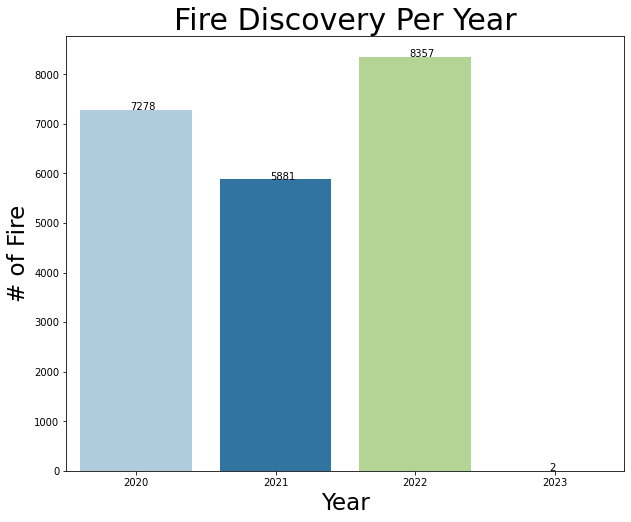

In [19]:
plot_by_arg(
    all_fire_weather,
    "firediscoverydatetime_year",
    figsize=(10, 8),
    title="Fire Discovery Per Year",
    xlabel="Year",
    ylabel="# of Fire",
    top_bar_count=True,
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    file_path='../../public/visuals/fire_by_year'
)


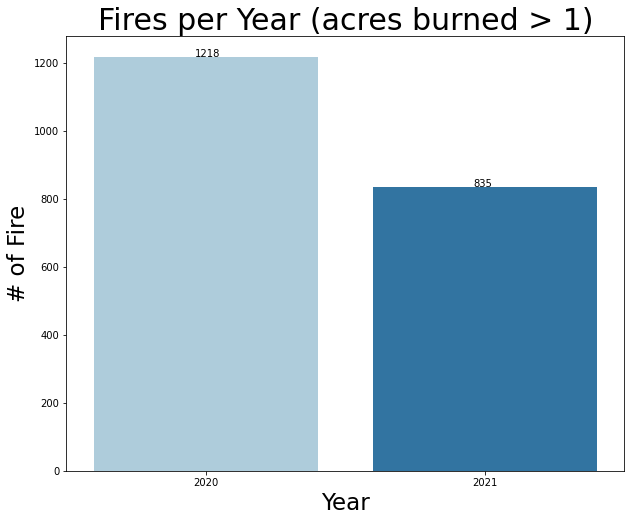

In [20]:
plot_by_arg(
    big_fire_weather,
    "firediscoverydatetime_year",
    figsize=(10, 8),
    title="Fires per Year (acres burned > 1)",
    xlabel="Year",
    ylabel="# of Fire",
    top_bar_count=True,
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    file_path='../../public/visuals/big_fire_by_year'
)


> Dataset we have mainly includes fire datasets from 3 years and 2022 when amount of fires has peaked between these years. Next I want to see what it looks like per month

# Fire By Month

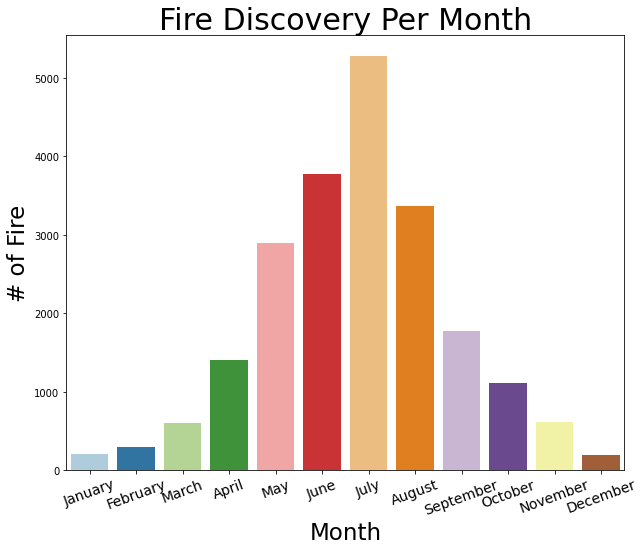

In [25]:
plot_by_arg(
    all_fire_weather,
    "firediscoverydatetime_month",
    figsize=(10, 8),
    title="Fire Discovery Per Month",
    xlabel="Month",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[1:],
    rotation=20,
    file_path='../../public/visuals/fire_by_month'
)


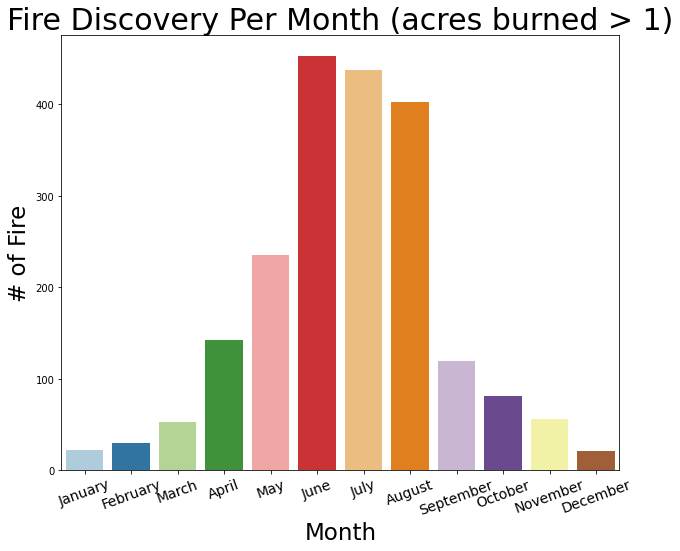

In [21]:
plot_by_arg(
    big_fire_weather,
    "firediscoverydatetime_month",
    figsize=(10, 8),
    title="Fire Discovery Per Month (acres burned > 1)",
    xlabel="Month",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[1:],
    rotation=20,
    file_path='../../public/visuals/big_fire_by_month'
)


> Charts show highest peak is between april and september. Next is interesting to look at which day of the week has most fires accrued for peak months

# Peak Fire Per Weekday By Month

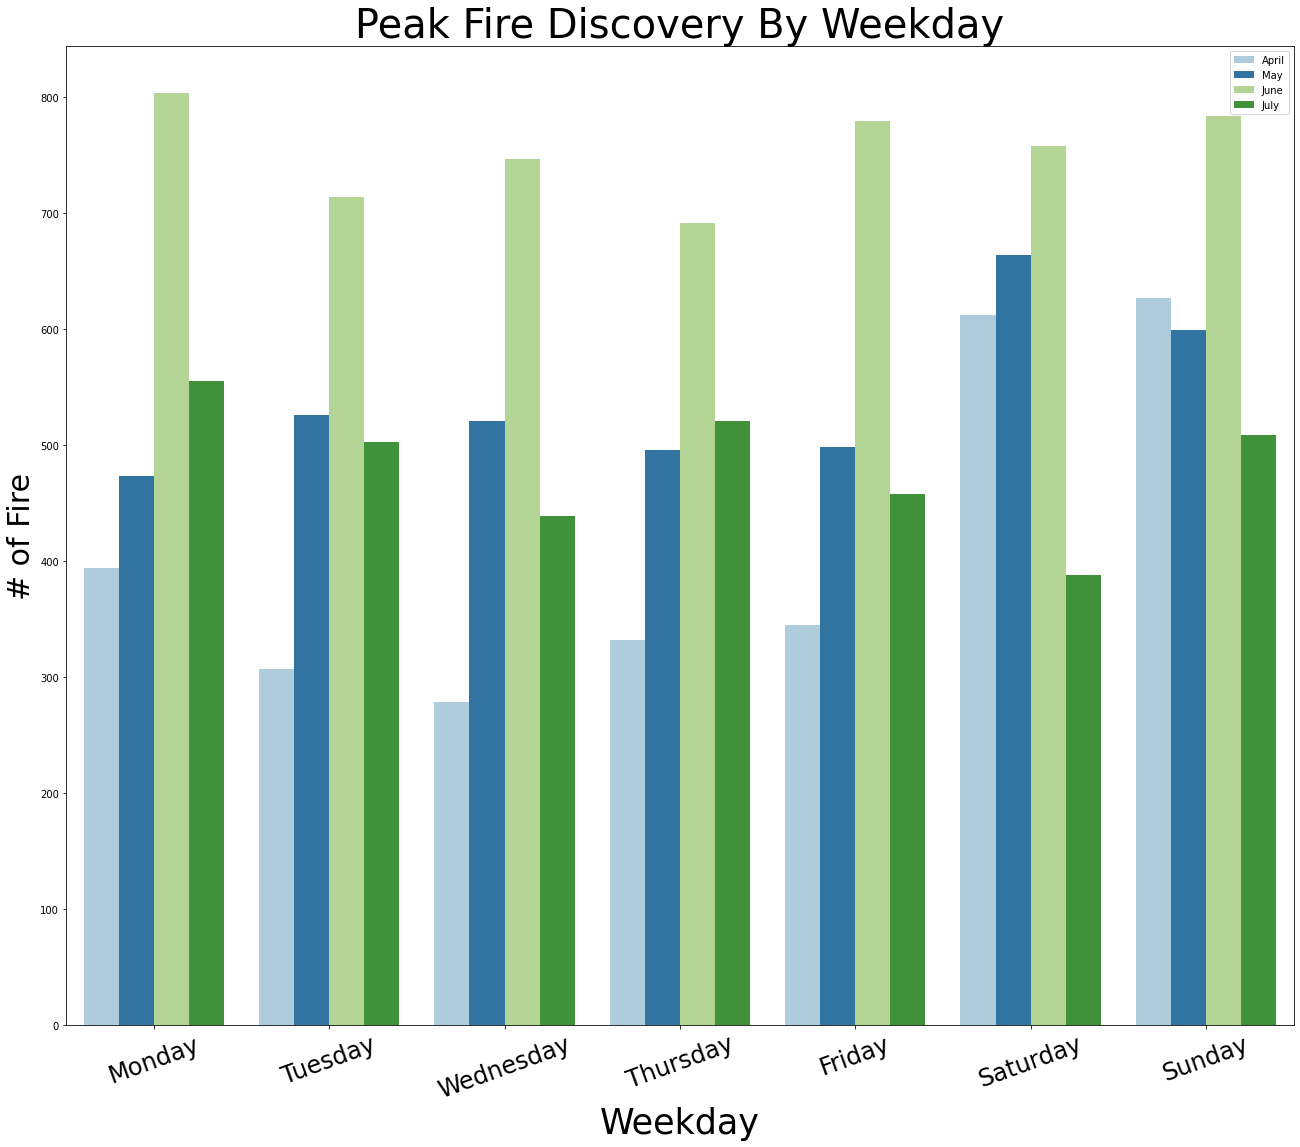

In [35]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(22, 18),
    title="Peak Fire Discovery By Weekday",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=40,
    xlabel_fontsize=35,
    ylabel_fontsize=30,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firediscoverydatetime_month",
    hue_labels=list(calendar.month_name)[4:10],
    file_path='../../public/visuals/peak_fire_by_weekday',
    xtick_fontsize=24
)


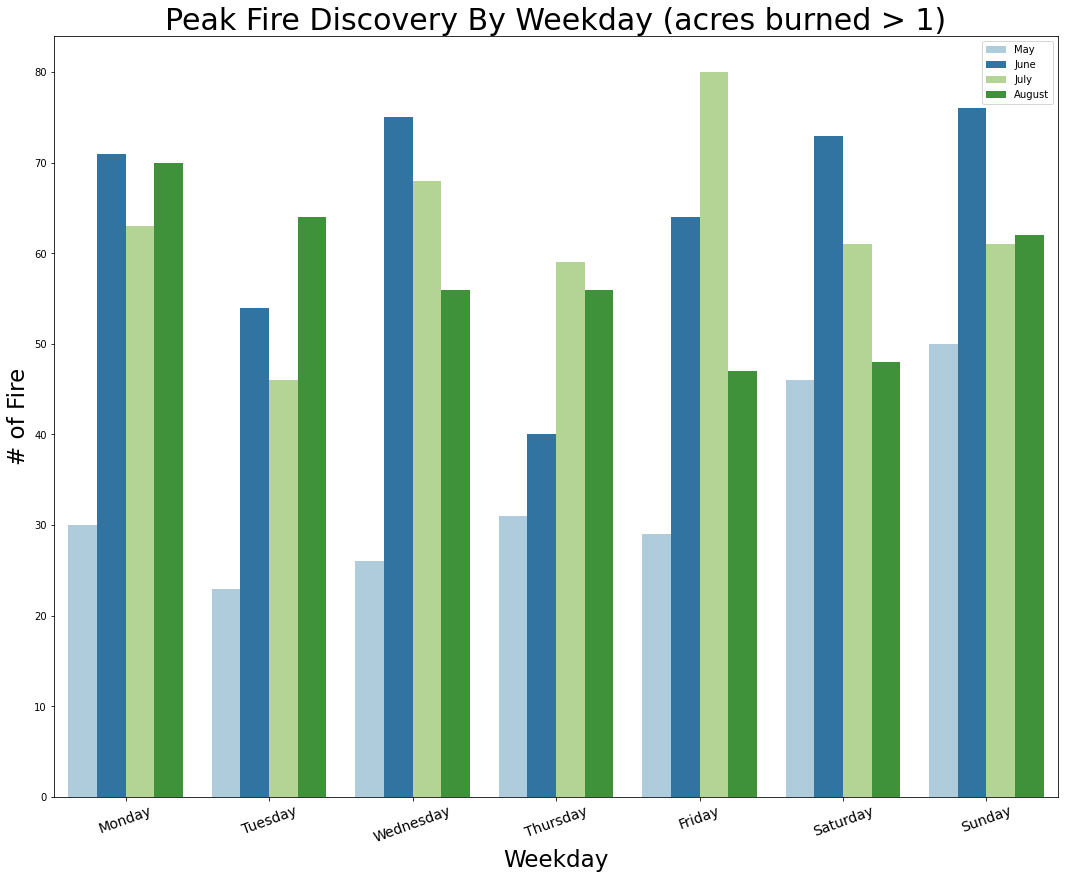

In [28]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(18, 14),
    title="Peak Fire Discovery By Weekday (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firediscoverydatetime_month",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:10],
    file_path='../../public/visuals/peak_big_fire_by_weekday'
)


> Chart shows that fires started regardless of day of the week. Next is interesting to look at what caused the fire during peak fire months

# Fire Cause During Peak Fire

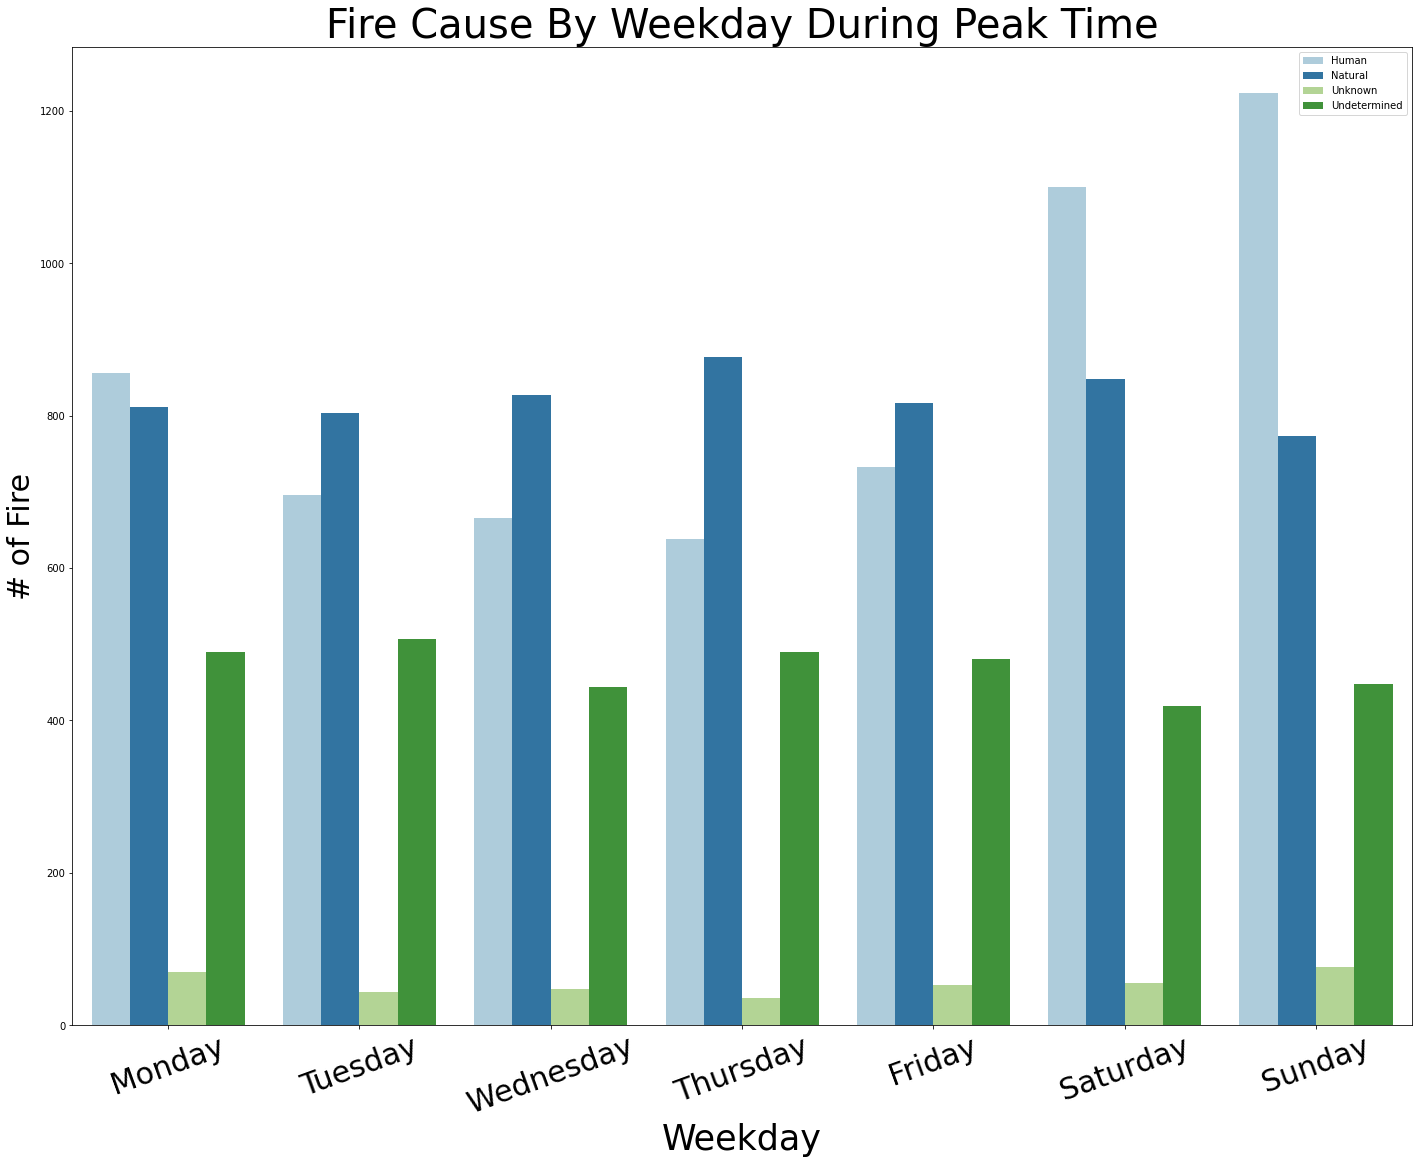

In [37]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(24, 18),
    title="Fire Cause By Weekday During Peak Time",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=40,
    xlabel_fontsize=35,
    ylabel_fontsize=30,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(all_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/peak_fire_cause_by_weekday',
    xtick_fontsize=30
)


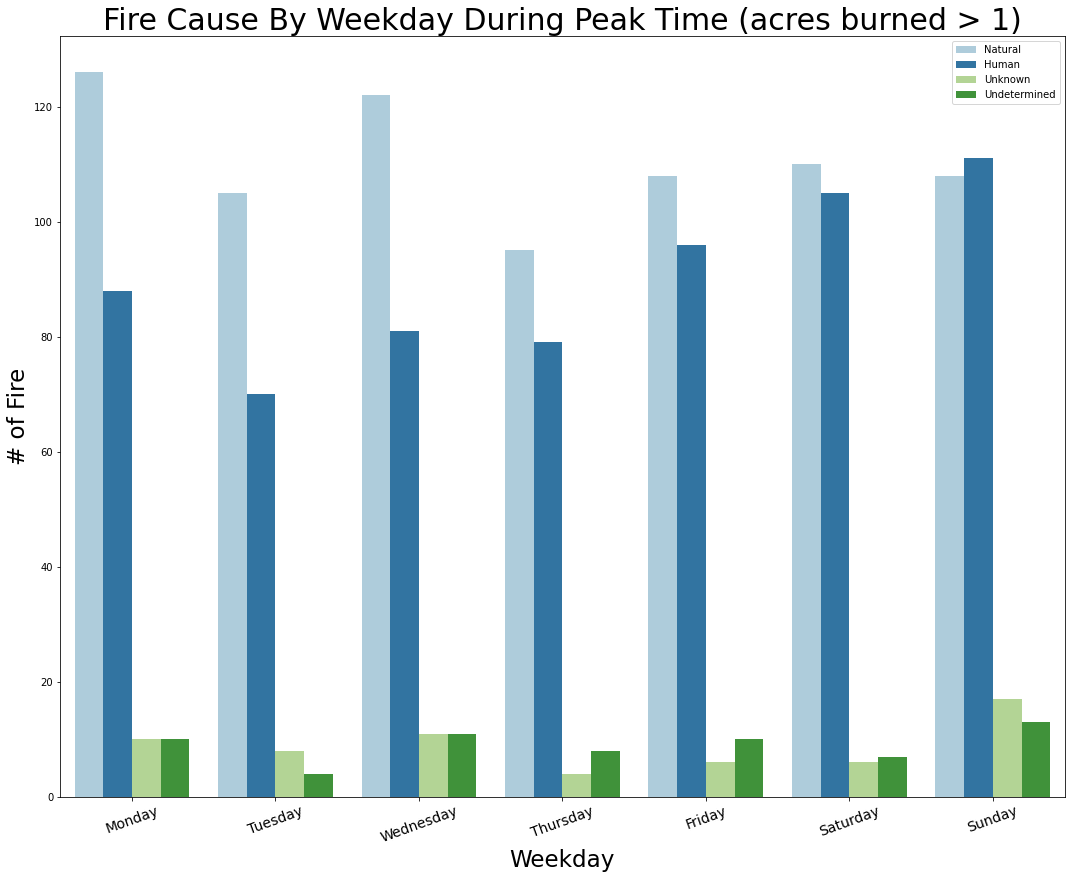

In [39]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(18, 14),
    title="Fire Cause By Weekday During Peak Time (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(big_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/peak_big_fire_by_weekday'
)


> Natural cause of fire dominates during weekday and human cause peaks during weekend which makes sense since more people go camping and increase the risk

----

# Fire Cause During Slow Time

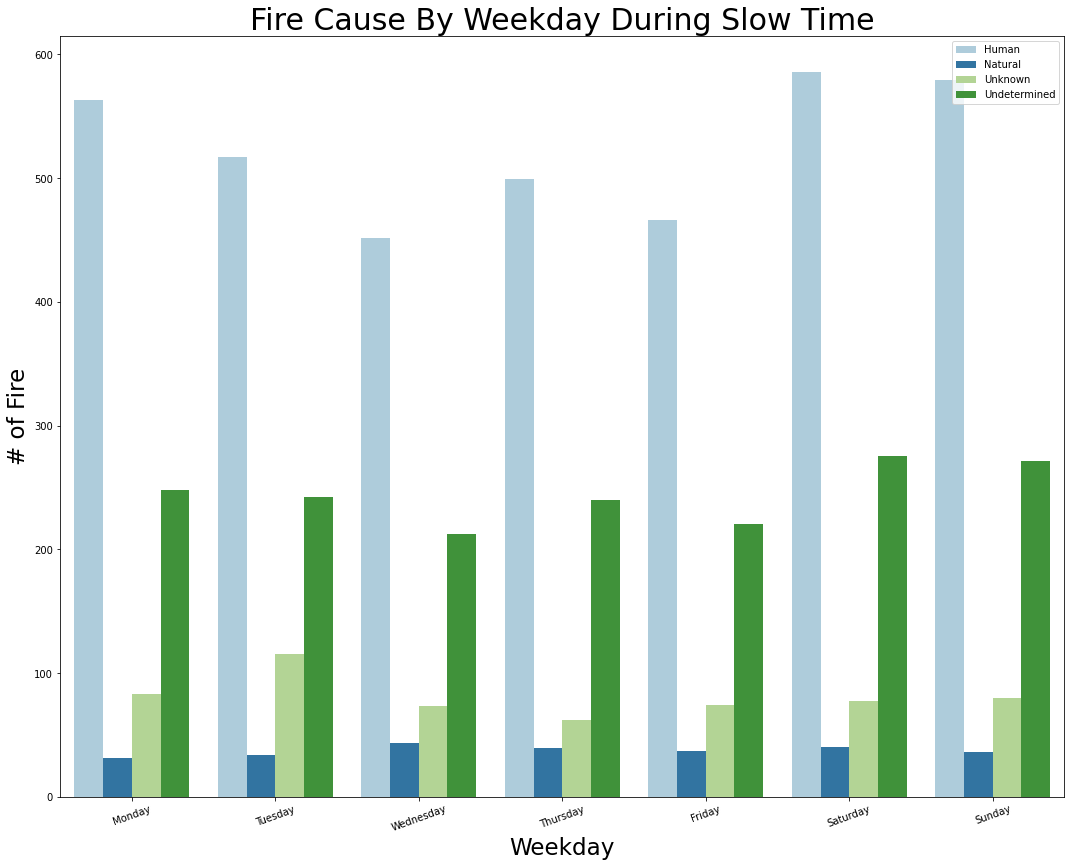

In [27]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] > peak_fire_month['max'])
        | (all_fire_weather["firediscoverydatetime_month"] < peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(18, 14),
    title="Fire Cause By Weekday During Slow Time",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(all_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/slow_fire_by_weekday'
)


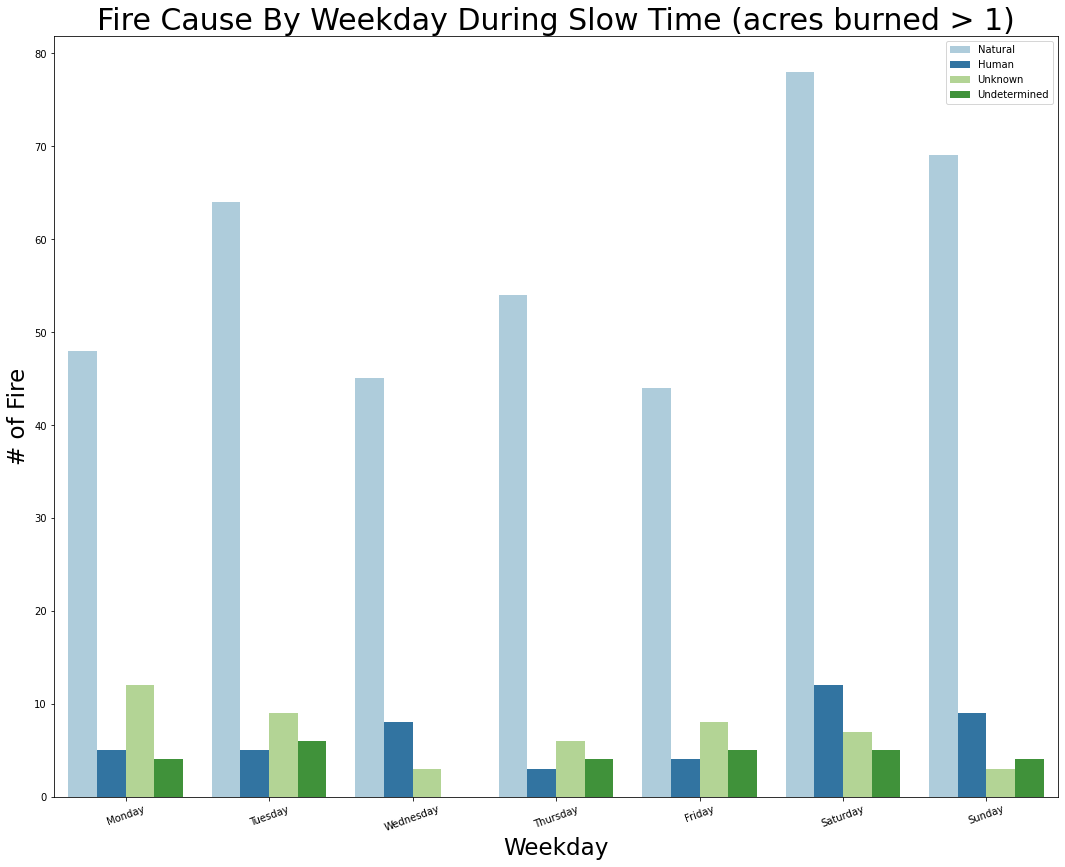

In [28]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] > peak_fire_month['max'])
        | (big_fire_weather["firediscoverydatetime_month"] < peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(18, 14),
    title="Fire Cause By Weekday During Slow Time (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(big_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/slow_big_fire_by_weekday'
)


> During slow fire season natural causes dominates across the board. Next it is interesting to find what is common conditions for peak fire.

----
# Peak Fire Common Conditions

- eliminate multicolinear columns

In [29]:
temp_cols = [col for col in all_fire_weather.columns if re.search("^(temp_)", col)]
wind_cols = [col for col in all_fire_weather.columns if re.search("^(wind_)", col)]
humid_cols = [col for col in all_fire_weather.columns if re.search("^(humid)", col)]
misc_cols = [
    "firediscoverydatetime_day",
    "firediscoverydatetime_month",
    "firediscoverydatetime_year",
    "controldatetime_day",
    "controldatetime_month",
    "controldatetime_year",
    "containmentdatetime_day",
    "containmentdatetime_month",
    "containmentdatetime_year",
]

cols_to_remove = np.concatenate((temp_cols[1:], wind_cols[1:], humid_cols[1:], misc_cols), axis=0)

C:\Users\btoli\AppData\Local\Temp\ipykernel_24696\108745531.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_fire_weather[


<AxesSubplot: >

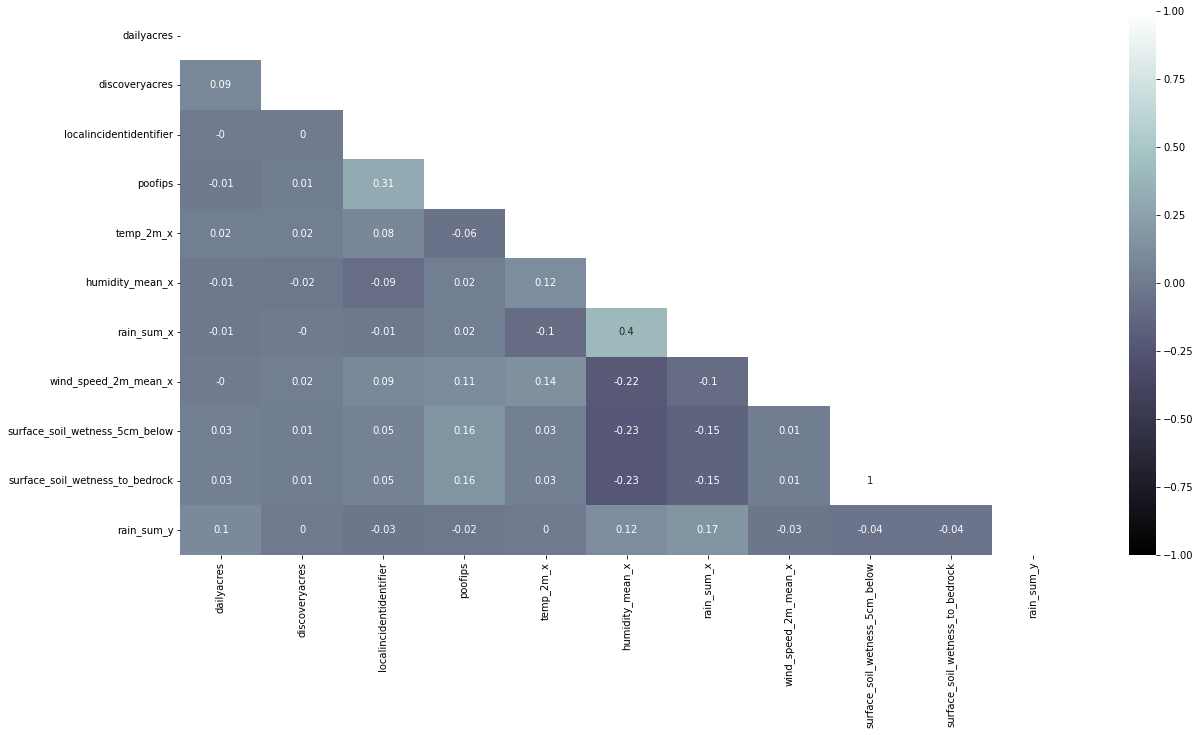

In [30]:
corr = (
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ]
    .drop(
        columns=cols_to_remove
    )
    .corr()
)

corr = round(corr, 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="bone",
    mask=mask,
)


C:\Users\btoli\AppData\Local\Temp\ipykernel_24696\217490632.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  big_fire_weather[


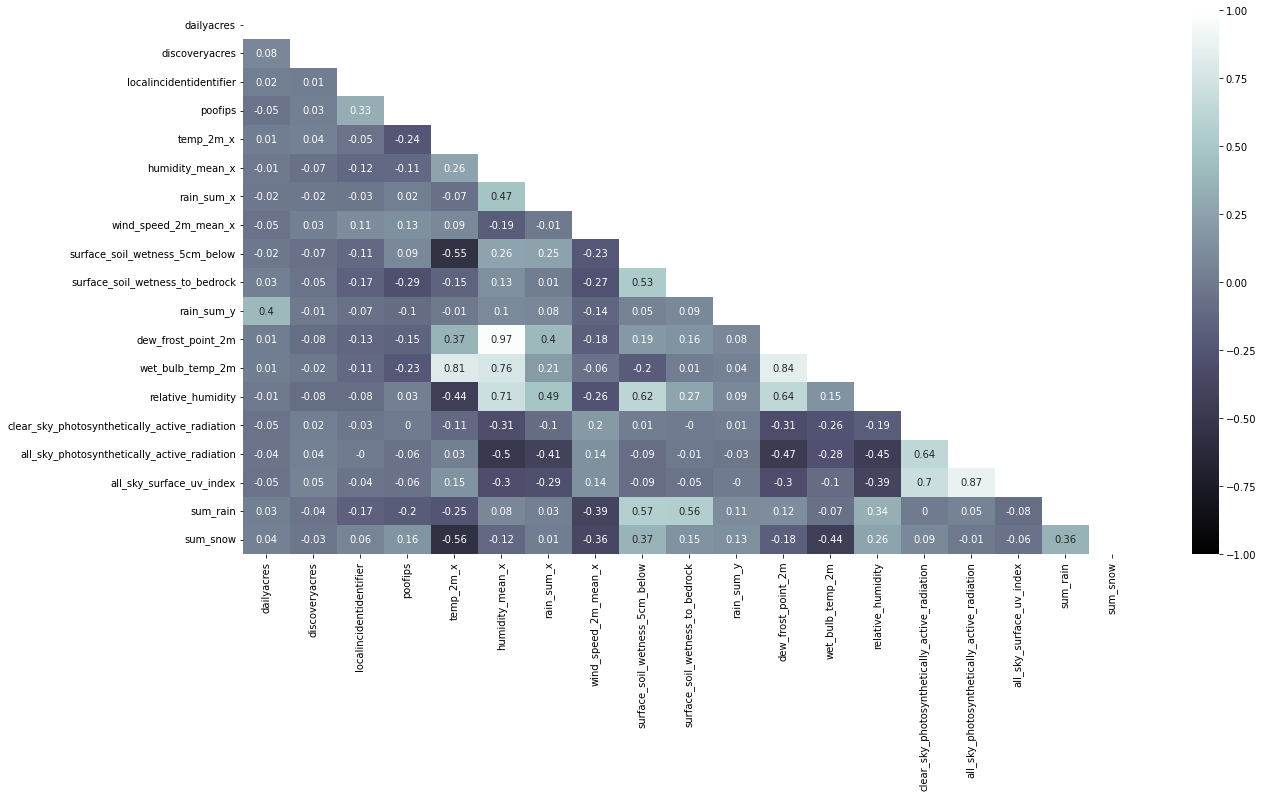

In [31]:
corr = (
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ]
    .drop(
        columns=cols_to_remove
    )
    .corr()
)

corr = round(corr, 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="bone",
    mask=mask,
);


- Temp at 2m: 
  - Wind Speed Gust at 2m Positive 0.18
- Humidity:
  - Wind Speed at 10m mean -0.27
  - Surface Soil Wetness to Bedrock -0.25

----


In [32]:
# 
temp_df = all_fire_weather.drop(columns=cols_to_remove)
temp_df.select_dtypes('O')


,firecause,poocounty,poostate
0,Human,Pinal,US-AZ
1,Natural,Elko,US-NV
2,Natural,Rio Blanco,US-CO
3,Human,Uintah,US-UT
4,Human,Cochise,US-AZ
...,...,...,...
21513,Human,Coconino,US-AZ
21514,Undetermined,Grant,US-NM
21515,Undetermined,Fresno,US-CA
21516,Undetermined,Curry,US-OR


----

# Peak Fire Discovery By State Per Month

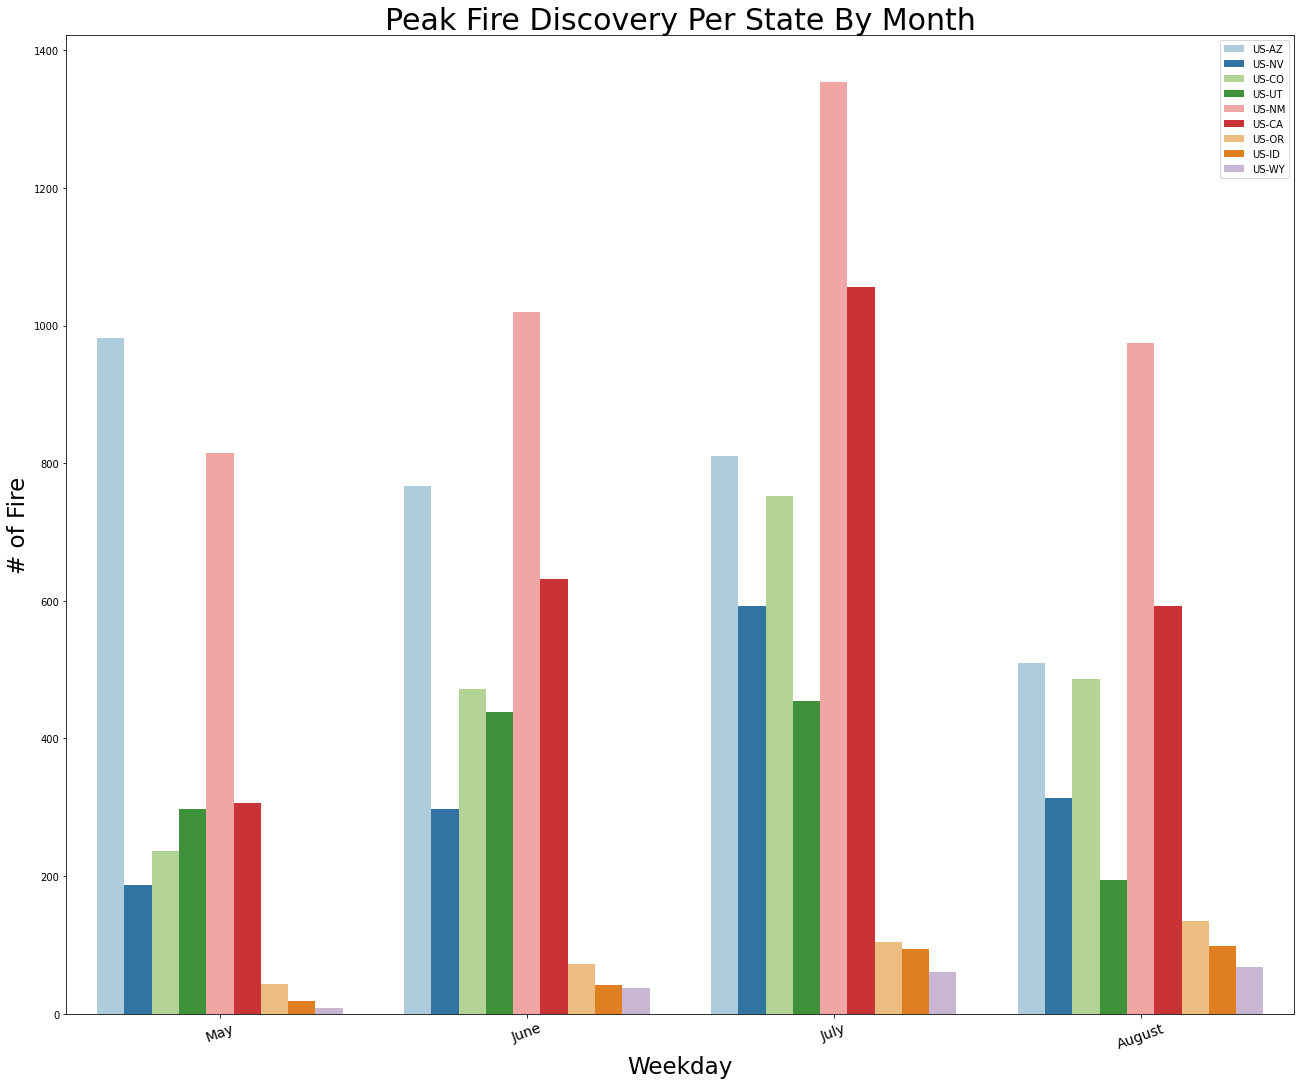

In [46]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_month",
    figsize=(22, 18),
    title="Peak Fire Discovery Per State By Month",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    rotation=20,
    hue="poostate",
    hue_labels=all_fire_weather['poostate'].unique(),
    file_path='../../public/visuals/fire_by_state_per_month'
)


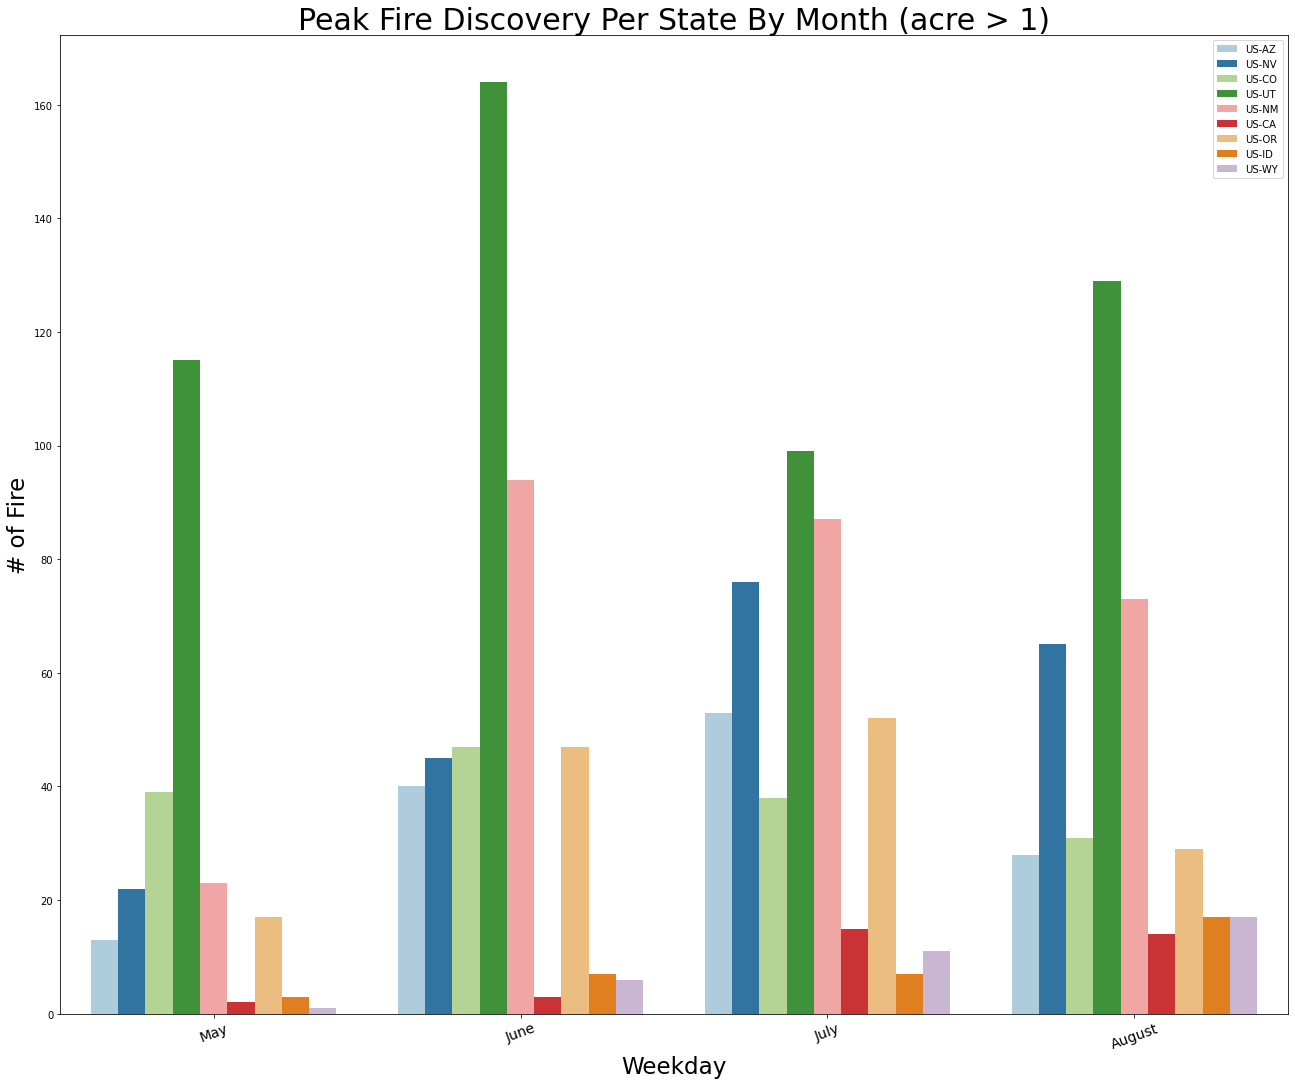

In [48]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_month",
    figsize=(22, 18),
    title="Peak Fire Discovery Per State By Month (acre > 1)",
    xlabel="Weekday",
    ylabel="# of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    rotation=20,
    hue="poostate",
    hue_labels=all_fire_weather['poostate'].unique(),
    file_path='../../public/visuals/big_fire_by_state_per_month'
)


----
# Peak Temperature By State

In [53]:
def plot_per_state(df, target, file_path, hue_labels, title, xlabel, ylabel, hue, xlimit=None):
    """Plots Horizontal bar graph based on given target by grouping by state and discovery month

    Args:
        df (Datafram): pandas dataframe
        target (string): target column
        file_path (string): file path to save the graph
        hue_labels (list): legend labels
        title (string): graph title
        xlabel (string): graph x line label
        ylabel (string): graph y line label
        hue (string): hue to divide the y line by
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    tdf = (
        df.groupby(["poostate", "firediscoverydatetime_month"])
        .max()[[target]]
        .reset_index()
    )

    sns.barplot(
        tdf,
        x=target,
        y="poostate",
        palette=sns.color_palette("tab10"),
        hue=hue,
        orient="h",
        ax=ax,
    )

    ax.set_title(title, fontsize=30, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    if xlimit:
        ax.set_xlim(xlimit)

    if hue_labels:
        ax.legend(
            loc="lower right",
            labels=hue_labels,
        )

    leg = ax.get_legend()
    for i in range(len(leg.legendHandles)):
        leg.legendHandles[i].set_color(sns.color_palette("tab10")[i])

    plt.savefig(file_path)


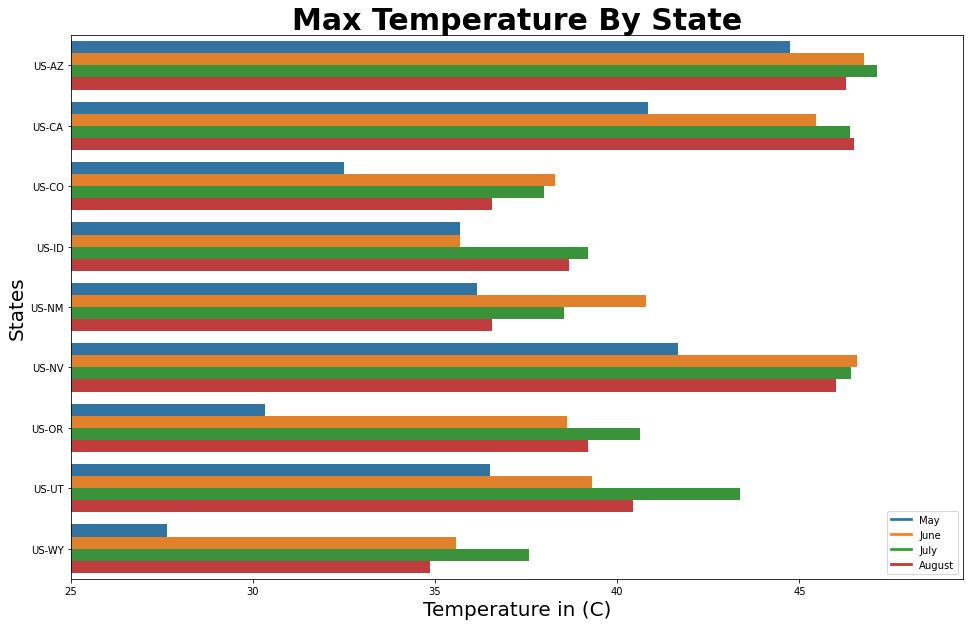

In [36]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="temp_2m_max",
    file_path="../../public/visuals/fire_max_temp_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Max Temperature By State',
    xlabel='Temperature in (C)',
    ylabel='States',
    hue='firediscoverydatetime_month',
    xlimit=25
)


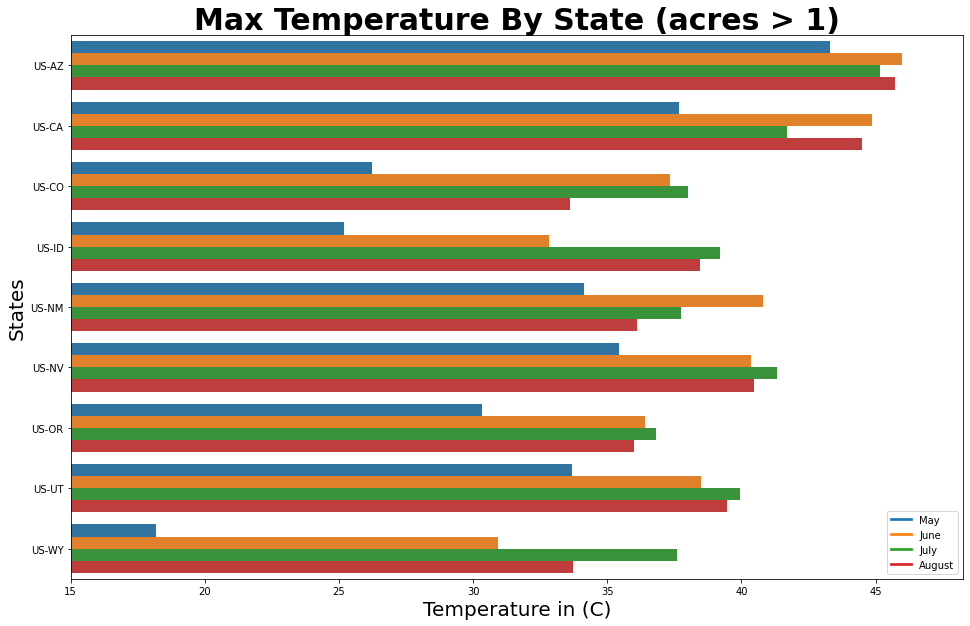

In [37]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="temp_2m_max",
    file_path="../../public/visuals/big_fire_max_temp_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Max Temperature By State (acres > 1)',
    xlabel='Temperature in (C)',
    ylabel='States',
    hue='firediscoverydatetime_month',
    xlimit=15
)


----
# Humidity By State At Peak Fire

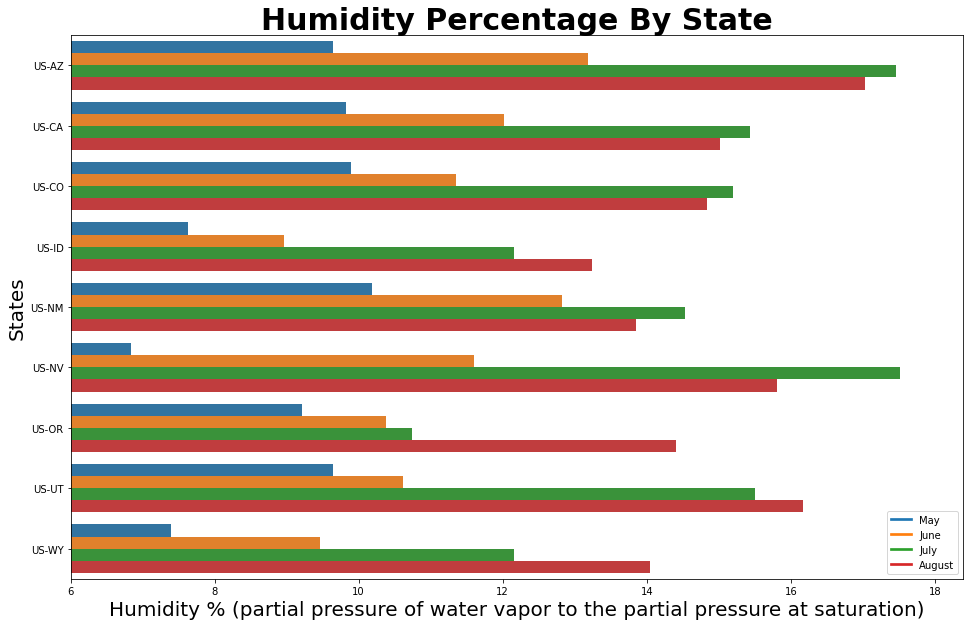

In [38]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="humidity_mean_x",
    file_path="../../public/visuals/fire_humidity_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Humidity Percentage By State',
    xlabel='Humidity % (partial pressure of water vapor to the partial pressure at saturation)',
    ylabel='States',
    hue='firediscoverydatetime_month',
    xlimit=6.0
)


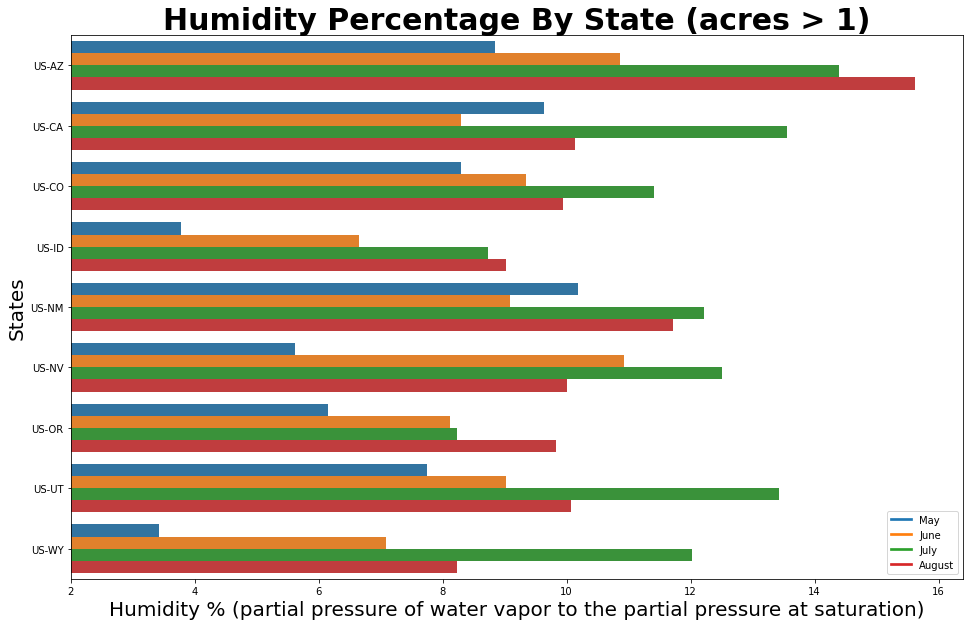

In [39]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="humidity_mean_x",
    file_path="../../public/visuals/big_fire_humidity_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Humidity Percentage By State (acres > 1)',
    xlabel='Humidity % (partial pressure of water vapor to the partial pressure at saturation)',
    ylabel='States',
    hue='firediscoverydatetime_month',
    xlimit=2
)


----
# Wind Speed By State

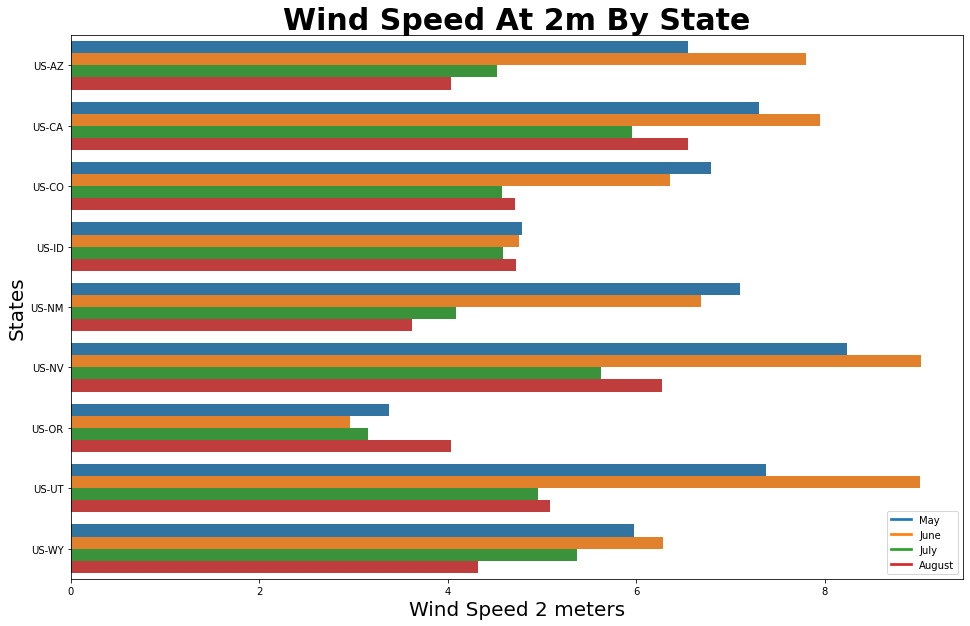

In [40]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="wind_speed_2m_mean_x",
    file_path="../../public/visuals/fire_wind_speed_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Wind Speed At 2m By State',
    xlabel='Wind Speed 2 meters',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


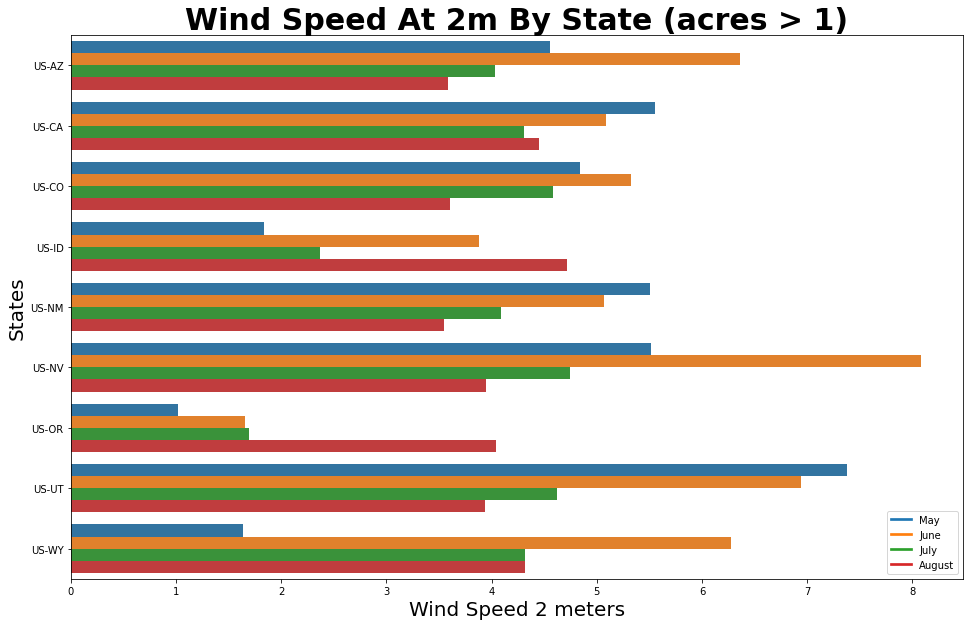

In [41]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="wind_speed_2m_mean_x",
    file_path="../../public/visuals/big_fire_wind_speed_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Wind Speed At 2m By State (acres > 1)',
    xlabel='Wind Speed 2 meters',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Rain By State

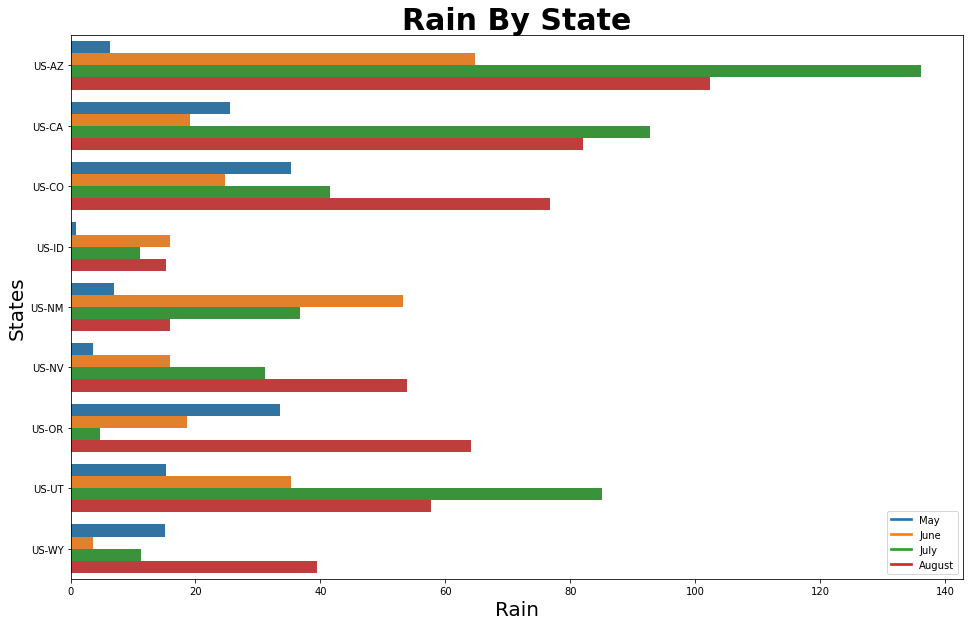

In [42]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum_x",
    file_path="../../public/visuals/fire_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Rain By State',
    xlabel='Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


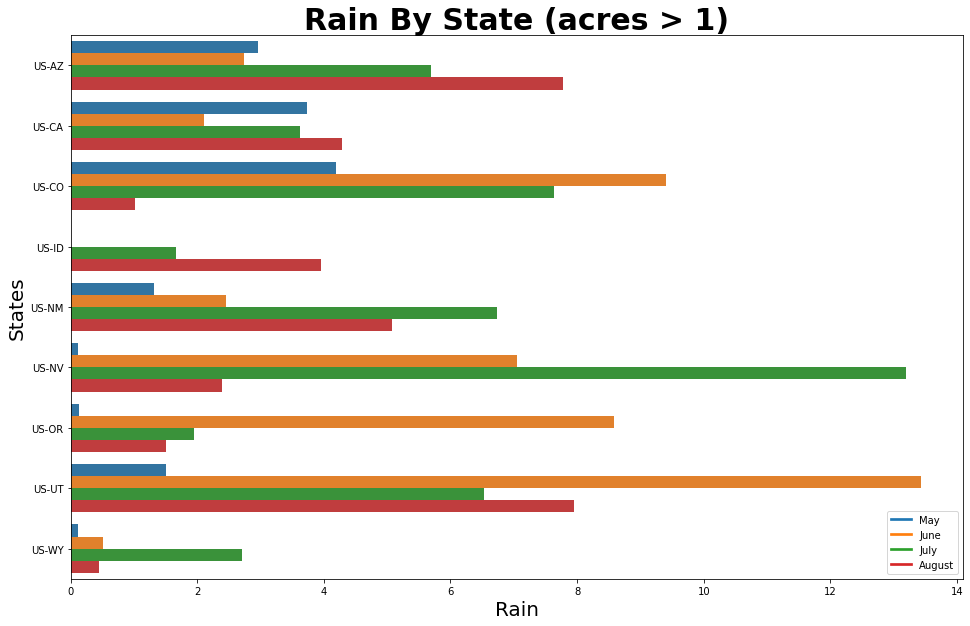

In [43]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum_x",
    file_path="../../public/visuals/big_fire_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Rain By State (acres > 1)',
    xlabel='Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Snow By State

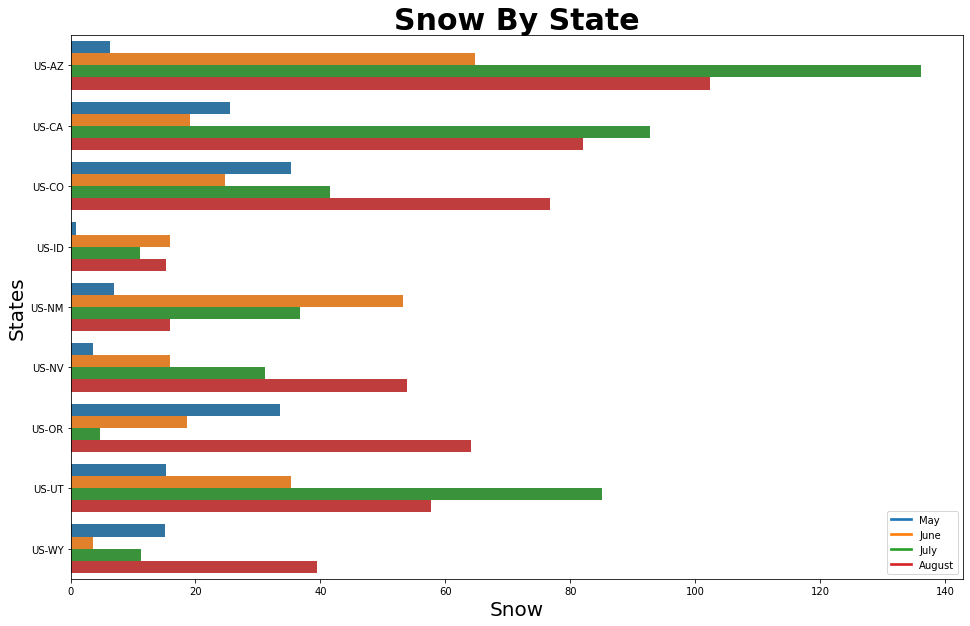

In [54]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum_x",
    file_path="../../public/visuals/fire_snow_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Snow By State',
    xlabel='Snow',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


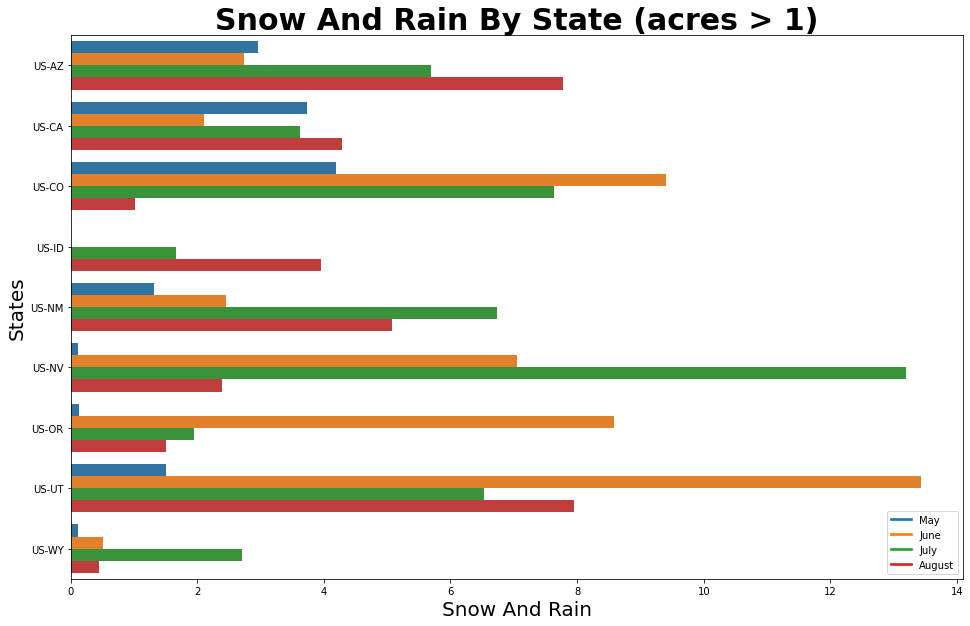

In [55]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum_x",
    file_path="../../public/visuals/big_fire_snow_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Snow And Rain By State (acres > 1)',
    xlabel='Snow And Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Time Took To Control By State

In [ ]:
all_fire_weather['time_took'] = all_fire_weather['controldatetime'] - all_fire_weather['firediscoverydatetime']
all_fire_weather['time_took'] = round(all_fire_weather['time_took'].dt.total_seconds()/60/60)

big_fire_weather['time_took'] = big_fire_weather['controldatetime'] - big_fire_weather['firediscoverydatetime']
big_fire_weather['time_took'] = round(big_fire_weather['time_took'].dt.total_seconds()/60/60)

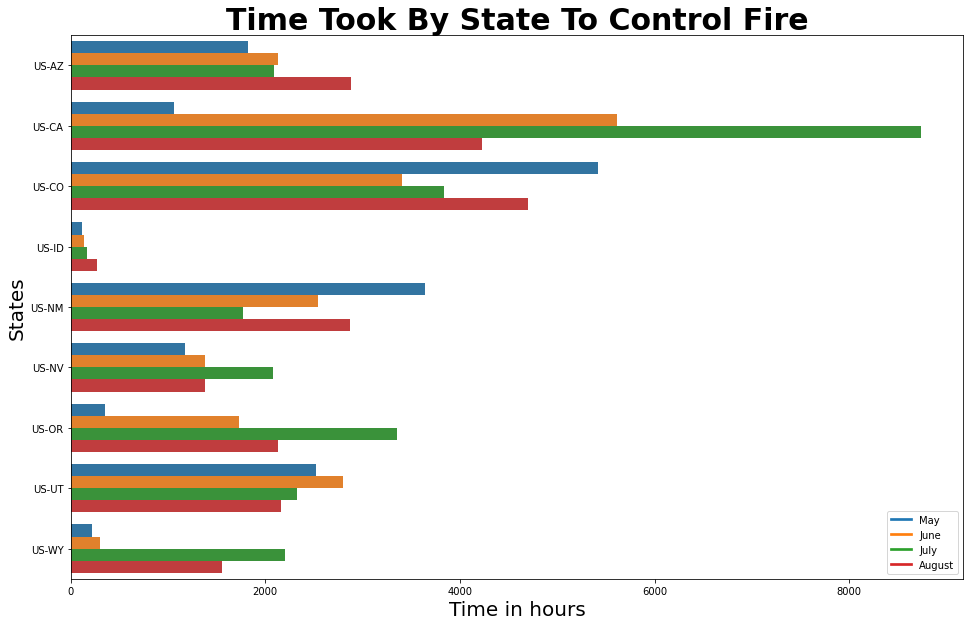

In [ ]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="time_took",
    file_path="../../public/visuals/fire_time_control_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Time Took By State To Control Fire',
    xlabel='Time in hours',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


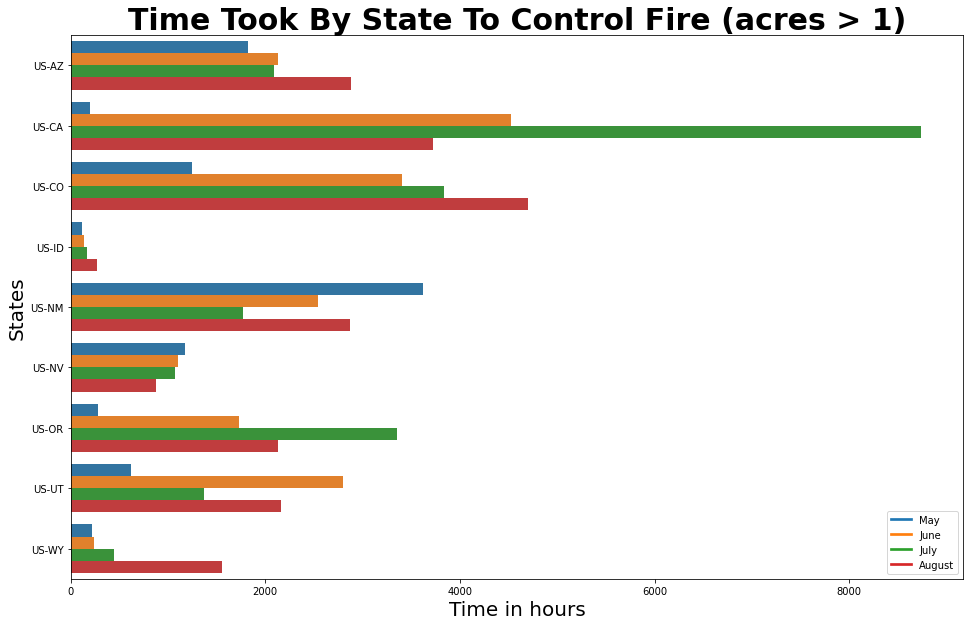

In [ ]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="time_took",
    file_path="../../public/visuals/big_fire_time_control_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Time Took By State To Control Fire (acres > 1)',
    xlabel='Time in hours',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


----

# Acres Burned By State

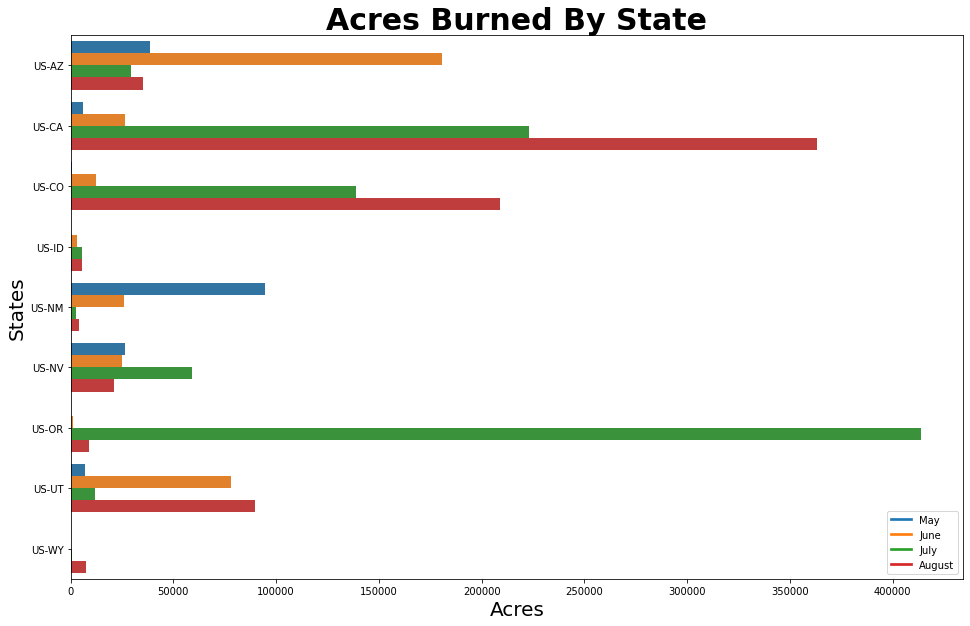

In [ ]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="dailyacres",
    file_path="../../public/visuals/fire_acres_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Acres Burned By State',
    xlabel='Acres',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


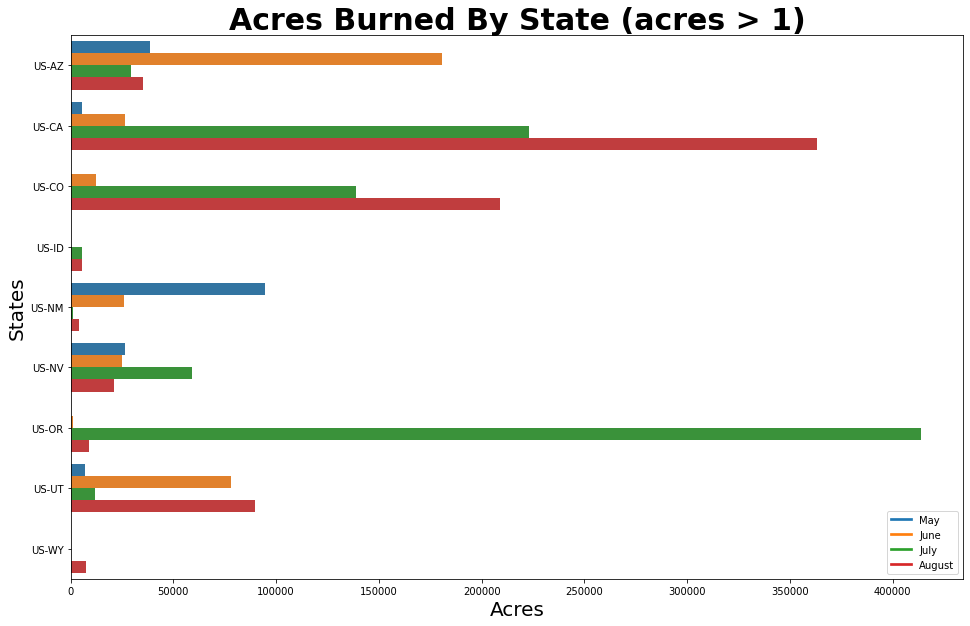

In [ ]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="dailyacres",
    file_path="../../public/visuals/big_fire_acres_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Acres Burned By State (acres > 1)',
    xlabel='Acres',
    ylabel='States',
    hue='firediscoverydatetime_month',
)
